# Test Weighted loss functions

## Run on an AWS g5.xlarge

In [1]:
import os
import io
import sys
import random
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import keras.backend as K

2024-12-28 19:15:35.486555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-28 19:15:35.502473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-28 19:15:35.507469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 19:15:35.519742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(f"Tensorflow version {tf.__version__}")
print("Python version:", sys.version.split(" ")[0])
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-Learn version:", sklearn.__version__)

Tensorflow version 2.17.0
Python version: 3.11.11
NumPy version: 1.26.4
Pandas version: 2.2.3
Scikit-Learn version: 1.5.2


In [3]:
random_state=42

random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Clear out all the folder structures

In [4]:
def clear_files_keep_folders(root_dir):
   """Delete all files in directory tree but keep the folder structure."""
   for dirpath, dirnames, filenames in os.walk(root_dir):
       for filename in filenames:
           file_path = os.path.join(dirpath, filename)
           try:
               os.remove(file_path)
               print(f"Deleted: {file_path}")
           except Exception as e:
               print(f"Error deleting {file_path}: {e}")

root_dirs = ["model_checkpoints", 'model_statistics', 'cache', 'dask_tmp']

for root_dir in root_dirs:
    os.makedirs(root_dir, exist_ok=True)
    clear_files_keep_folders(root_dir)

Deleted: model_statistics/training_history.csv


# Set system clock

In [5]:
!sudo timedatectl set-timezone US/Mountain

# Load global variables

In [6]:
import pickle


with open('saved_variables/data_files.pkl', 'rb') as f:
    data_files = pickle.load(f)

for key, value in data_files.items():
    if key.startswith('df_'):
        # For dataframes, print head(2) instead of full frame
        print(f"\n{key}:")
        print(f"{value.shape})")
        display(value.head(2))
    elif key == 'y_true' and isinstance(value, (list, tuple, np.ndarray)):
        # If 'y_true' is found, display its shape
        print(f"\n{key:<25} shape = {value.shape}")
    else:
        # For other variables, print normally
        print(f"{key:<25} = {value}")

for key, value in data_files.items():
    globals()[key] = value

batch_size                = 128
test_batch_size           = 128
target_w                  = 256
target_h                  = 256
input_shape               = (256, 256, 3)
target_size               = (256, 256)
dataset_size              = 112122
local_image_directory     = nih_xrays_256
num_labels                = 5
label_text                = ['Infiltration', 'Effusion', 'Atelectasis', 'Nodule', 'Mass']
dask_chunk_size           = 30

y_true                    shape = (10828, 5)

df_train:
(90005, 7))


,Image,PatientId,Infiltration,Effusion,Atelectasis,Nodule,Mass
0,00022260_003.png,22260,0,0,0,0,0
1,00012048_007.png,12048,1,0,0,1,1



df_val:
(11257, 7))


,Image,PatientId,Infiltration,Effusion,Atelectasis,Nodule,Mass
12,00014663_050.png,14663,0,0,0,1,0
16,00006832_004.png,6832,0,0,0,1,1



df_test:
(10858, 7))


,Image,PatientId,Infiltration,Effusion,Atelectasis,Nodule,Mass
6,00003446_008.png,3446,0,0,0,0,0
33,00001698_002.png,1698,0,0,0,0,0


### Override global variables

In [7]:
target_w                  = 320
target_h                  = 320
input_shape               = (320, 320, 3)
target_size               = (320, 320)
dataset_size              = 112120
local_image_directory     = 'nih_xrays_320'
y_pred_threshold_gt       = 0.50

# Sample an image before preprocessing


Image Analysis for: nih_xrays_320/00021092_007.png
--------------------------------------------------
File path: nih_xrays_320/00021092_007.png
File size: 41.65 KB

PIL Image Info:
Format: PNG
Mode: L
Size (width x height): (320, 320)
Color palette: No

NumPy Array Info:
Shape: (320, 320)
Data type: uint8
Number of dimensions: 2
Number of channels: 1
Min value: 0
Max value: 241
Mean value: 135.21


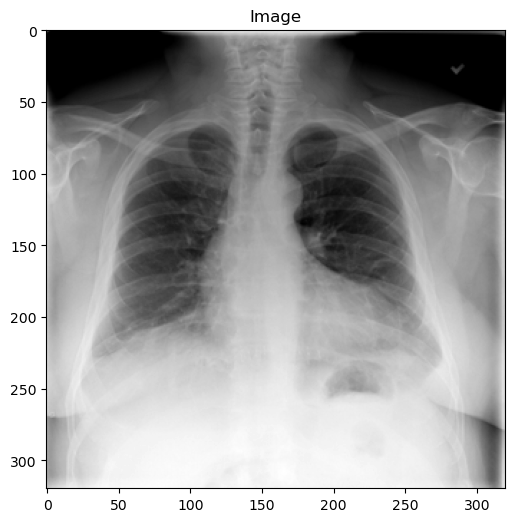

In [8]:
from PIL import Image as PIL_Image
import matplotlib.pyplot as plt

def analyze_random_image(directory):
    # Get list of all PNG files
    png_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                png_files.append(os.path.join(root, file))
    
    if not png_files:
        print("No PNG files found in directory!")
        return
    
    # Select random image
    random_image_path = random.choice(png_files)
    # random_image_path_for_post_preprocessing = random_image_path
    
    # Open with PIL
    img_pil = PIL_Image.open(random_image_path)
    
    # Convert to numpy array
    img_array = np.array(img_pil)
    # img_array = tf.image.grayscale_to_rgb(img_array)
    
    # Gather metadata
    print(f"\nImage Analysis for: {directory}/{os.path.basename(random_image_path)}")
    print("-" * 50)
    print(f"File path: {random_image_path}")
    print(f"File size: {os.path.getsize(random_image_path) / 1024:.2f} KB")
    print("\nPIL Image Info:")
    print(f"Format: {img_pil.format}")
    print(f"Mode: {img_pil.mode}")
    print(f"Size (width x height): {img_pil.size}")
    print(f"Color palette: {'Yes' if img_pil.palette else 'No'}")
    
    print("\nNumPy Array Info:")
    print(f"Shape: {img_array.shape}")
    print(f"Data type: {img_array.dtype}")
    print(f"Number of dimensions: {img_array.ndim}")
    print(f"Number of channels: {img_array.shape[-1] if img_array.ndim > 2 else 1}")
    print(f"Min value: {img_array.min()}")
    print(f"Max value: {img_array.max()}")
    print(f"Mean value: {img_array.mean():.2f}")
    
    # Display the image
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_array, cmap='gray' if img_array.ndim == 2 else None)
    plt.title("Image")
    plt.axis('on')
    
    if img_array.ndim > 2:
        plt.subplot(1, 2, 2)
        plt.hist(img_array.ravel(), bins=256, density=True, alpha=0.7)
        plt.title("Pixel Value Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    
    # return img_array, img_pil

# Run the analysis
analyze_random_image(directory=local_image_directory)

# Weighted Loss Functions

## WeightedBinaryCrossEntropy_1 loss function

In [9]:
def WeightedBinaryCrossEntropy_1a(pos_weights, neg_weights):
    """
    Enhanced weighted binary cross-entropy with focus on specificity
    """
    pos_weights = tf.constant(pos_weights, dtype=tf.float32)
    neg_weights = tf.constant(neg_weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Separate positive and negative cases
        pos_term = y_true * tf.math.log(y_pred) * pos_weights
        neg_term = (1 - y_true) * tf.math.log(1 - y_pred) * neg_weights
        
        # Calculate per-class losses
        loss_per_class = -(pos_term + neg_term)
        
        # Return mean loss
        return tf.reduce_mean(tf.reduce_sum(loss_per_class, axis=-1))
    
    return loss

In [10]:
def WeightedBinaryCrossEntropy_1b(pos_weights, neg_weights):
    """
    Enhanced weighted binary cross-entropy with weight normalization
    """
    pos_weights = tf.constant(pos_weights, dtype=tf.float32)
    neg_weights = tf.constant(neg_weights, dtype=tf.float32)
    
    # Normalize weights to sum to 1
    total = pos_weights + neg_weights
    pos_weights = pos_weights / total
    neg_weights = neg_weights / total
    
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        pos_term = y_true * tf.math.log(y_pred) * pos_weights
        neg_term = (1 - y_true) * tf.math.log1p(-y_pred) * neg_weights
        
        loss_per_class = -(pos_term + neg_term)
        return tf.reduce_mean(tf.reduce_sum(loss_per_class, axis=-1))
    
    return loss

In [11]:
def WeightedBinaryCrossEntropy_1c(pos_weights, neg_weights):
    """
    Enhanced weighted binary cross-entropy with weight normalization.

    Args:
        pos_weights (list or array-like): Positive class weights for each label.
        neg_weights (list or array-like): Negative class weights for each label.

    Returns:
        loss (function): A loss function that takes (y_true, y_pred) as inputs and returns the computed loss.

    Example:
        pos_weights = [2.0, 1.0, 0.5]
        neg_weights = [0.5, 1.0, 2.0]
        loss_fn = WeightedBinaryCrossEntropy_1c(pos_weights, neg_weights)
        model.compile(optimizer='adam', loss=loss_fn)
    """
    pos_weights = tf.constant(pos_weights, dtype=tf.float32)
    neg_weights = tf.constant(neg_weights, dtype=tf.float32)

    # Normalize weights to sum to 1 for each class
    total = pos_weights + neg_weights
    pos_weights = pos_weights / total
    neg_weights = neg_weights / total

    def loss(y_true, y_pred):
        """
        Computes the weighted binary cross-entropy loss for multi-label classification.

        Args:
            y_true (tensor): Ground truth labels, shape (batch_size, num_classes).
            y_pred (tensor): Predicted probabilities, shape (batch_size, num_classes).

        Returns:
            loss (tensor): Scalar tensor representing the mean loss.
        """
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Calculate weighted loss terms for positive and negative classes
        pos_term = y_true * tf.math.log(y_pred) * pos_weights
        neg_term = (1 - y_true) * tf.math.log1p(-y_pred) * neg_weights

        # Compute per-class loss
        loss_per_class = -(pos_term + neg_term)

        # Return mean loss across all classes and samples
        return tf.reduce_mean(tf.reduce_sum(loss_per_class, axis=-1))

    return loss

## WeightedBinaryCrossEntropy_2 loss function

In [12]:


class WeightedBinaryCrossEntropy_2a(tf.keras.losses.Loss):
    def __init__(self, pos_weights, neg_weights, **kwargs):
        super().__init__(**kwargs)
        self.pos_weights = tf.constant(pos_weights, dtype=tf.float32)
        self.neg_weights = tf.constant(neg_weights, dtype=tf.float32)
    
    def call(self, y_true, y_pred):
        # Clip prediction values to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Calculate losses separately for positive and negative cases
        pos_loss = -self.pos_weights * y_true * tf.math.log(y_pred)
        neg_loss = -self.neg_weights * (1 - y_true) * tf.math.log(1 - y_pred)
        
        return tf.reduce_mean(pos_loss + neg_loss)


In [13]:
class WeightedBinaryCrossEntropy_2b(tf.keras.losses.Loss):
    """
    Custom weighted binary cross-entropy loss for multi-label classification.

    This loss function applies separate positive and negative weights to each class 
    and normalizes them to ensure stability during training.

    Args:
        pos_weights (list or array-like): Positive class weights for each label.
        neg_weights (list or array-like): Negative class weights for each label.

    Example:
        pos_weights = [2.0, 1.0, 0.5]
        neg_weights = [0.5, 1.0, 2.0]
        loss_fn = WeightedBinaryCrossEntropy_2b(pos_weights, neg_weights)
        model.compile(optimizer='adam', loss=loss_fn)
    """

    def __init__(self, pos_weights, neg_weights, **kwargs):
        super().__init__(**kwargs)
        # Convert weights to TensorFlow constants
        pos_weights = tf.constant(pos_weights, dtype=tf.float32)
        neg_weights = tf.constant(neg_weights, dtype=tf.float32)
        
        # Normalize weights so that pos_weights + neg_weights = 1 for each class
        total_weights = pos_weights + neg_weights
        self.pos_weights = pos_weights / total_weights
        self.neg_weights = neg_weights / total_weights

    def call(self, y_true, y_pred):
        """
        Computes the weighted binary cross-entropy loss.

        Args:
            y_true (tensor): Ground truth labels, shape (batch_size, num_classes).
            y_pred (tensor): Predicted probabilities, shape (batch_size, num_classes).

        Returns:
            loss (tensor): Scalar tensor representing the mean loss.
        """
        # Clip predictions to prevent log(0) or log(1) errors
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

        # Get shapes and check if they match using tf.Assert
        true_shape = tf.shape(y_true)[-1]
        weight_shape = tf.shape(self.pos_weights)[-1]
        
        tf.debugging.assert_equal(
            true_shape,
            weight_shape,
            message="Mismatch between number of classes in y_true and weights."
        )

        # Calculate weighted loss
        weighted_loss = -(
            y_true * self.pos_weights * tf.math.log(y_pred) +
            (1 - y_true) * self.neg_weights * tf.math.log(1 - y_pred)
        )

        # Return mean loss across samples and classes
        return tf.reduce_mean(weighted_loss)

In [14]:
class WeightedBinaryCrossEntropy_2c(tf.keras.losses.Loss):
   """
   Custom weighted binary cross-entropy loss for multi-label classification.
   Applies separate positive and negative weights per class with normalization.
   
   Args:
       pos_weights (list/array): Positive class weights per label
       neg_weights (list/array): Negative class weights per label
       sample_weight (tensor, optional): Per-sample weights
       
   Example:
       loss_fn = WeightedBinaryCrossEntropy_2c([2.0, 1.0], [0.5, 1.0])
       model.compile(optimizer='adam', loss=loss_fn)
   """
   def __init__(self, pos_weights, neg_weights, **kwargs):
       super().__init__(**kwargs)
       
       # Validate and convert weights
       pos_weights = tf.constant(pos_weights, dtype=tf.float32)
       neg_weights = tf.constant(neg_weights, dtype=tf.float32)
       
       if tf.reduce_any(pos_weights < 0) or tf.reduce_any(neg_weights < 0):
           raise ValueError("Weights must be non-negative")
           
       if tf.size(pos_weights) != tf.size(neg_weights):
           raise ValueError("pos_weights and neg_weights must have same shape")
           
       # Normalize weights per class
       total_weights = pos_weights + neg_weights
       self.pos_weights = pos_weights / total_weights
       self.neg_weights = neg_weights / total_weights
       
   def call(self, y_true, y_pred, sample_weight=None):
       """
       Computes weighted BCE loss with improved numerical stability
       
       Args:
           y_true: Ground truth labels (batch_size, num_classes)
           y_pred: Predicted probabilities (batch_size, num_classes)
           sample_weight: Optional per-sample weights
           
       Returns:
           Scalar loss tensor
       """
       # Validate shapes
       tf.debugging.assert_shapes([
           (y_true, ('N', 'C')),
           (y_pred, ('N', 'C')),
           (self.pos_weights, ('C',))
       ])
       
       # Clip predictions
       epsilon = tf.keras.backend.epsilon()
       y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
       
       # Calculate loss with improved stability
       weighted_loss = -(
           y_true * self.pos_weights * tf.math.log(y_pred) +
           (1 - y_true) * self.neg_weights * tf.math.log1p(-y_pred)
       )
       
       # Apply sample weights if provided
       if sample_weight is not None:
           weighted_loss *= tf.expand_dims(sample_weight, axis=-1)
           
       return tf.reduce_mean(weighted_loss)

## Alternative Loss Functions

In [15]:
import tensorflow as tf

class FocalWeightedBCE(tf.keras.losses.Loss):
   """
   Focal Loss variant of weighted BCE. Adds scaling factor to focus on hard examples.
   
   Args:
       pos_weights: Positive class weights (array-like)
       neg_weights: Negative class weights (array-like) 
       gamma: Focusing parameter (default=2.0). Higher values increase focus on hard examples
       
   Example:
       # Binary classification with class imbalance and hard examples
       pos_w = [0.7]  # Minority class
       neg_w = [0.3]  # Majority class
       loss_fn = FocalWeightedBCE(pos_w, neg_w, gamma=2.0)
       model.compile(optimizer='adam', loss=loss_fn)
   """
   def __init__(self, pos_weights, neg_weights, gamma=2.0):
       super().__init__()
       self.pos_weights = tf.constant(pos_weights, dtype=tf.float32)
       self.neg_weights = tf.constant(neg_weights, dtype=tf.float32)
       self.gamma = gamma
       
   def call(self, y_true, y_pred):
       epsilon = tf.keras.backend.epsilon()
       y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
       
       bce = -(y_true * self.pos_weights * tf.math.log(y_pred) + 
               (1-y_true) * self.neg_weights * tf.math.log1p(-y_pred))
               
       focal_factor = tf.pow(1-y_pred, self.gamma) * y_true + tf.pow(y_pred, self.gamma) * (1-y_true)
       return tf.reduce_mean(bce * focal_factor)

class DynamicWeightedBCE(tf.keras.losses.Loss):
   """
   Dynamic weighting based on batch statistics. Adapts weights during training.
   
   Example:
       # For dataset with varying class distributions
       loss_fn = DynamicWeightedBCE()
       model.compile(optimizer='adam', loss=loss_fn)
   """
   def call(self, y_true, y_pred):
       epsilon = tf.keras.backend.epsilon()
       y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
       
       # Calculate class ratios per batch
       pos_ratio = tf.reduce_mean(y_true, axis=0)
       pos_weights = 1.0 / (pos_ratio + epsilon)
       neg_weights = 1.0 / (1.0 - pos_ratio + epsilon)
       
       return -tf.reduce_mean(
           y_true * pos_weights * tf.math.log(y_pred) +
           (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
       )

class DynamicWeightedBCE_temp(tf.keras.losses.Loss):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
        
        # Temperature scaling for smoother gradients
        y_pred = y_pred ** (1/self.temperature)
        
        # Calculate class ratios per batch
        pos_ratio = tf.reduce_mean(y_true, axis=0)
        pos_weights = 1.0 / (pos_ratio + epsilon)
        neg_weights = 1.0 / (1.0 - pos_ratio + epsilon)
        
        return -tf.reduce_mean(
            y_true * pos_weights * tf.math.log(y_pred) +
            (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
        )

class DynamicWeightedBCE_wgt_smooth(tf.keras.losses.Loss):
    def __init__(self, smoothing_factor=0.1):
        super().__init__()
        self.smoothing_factor = smoothing_factor
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
        
        # Calculate class ratios with smoothing
        pos_ratio = tf.reduce_mean(y_true, axis=0)
        smoothed_ratio = pos_ratio * (1 - self.smoothing_factor) + 0.5 * self.smoothing_factor
        
        pos_weights = 1.0 / (smoothed_ratio + epsilon)
        neg_weights = 1.0 / (1.0 - smoothed_ratio + epsilon)
        
        return -tf.reduce_mean(
            y_true * pos_weights * tf.math.log(y_pred) +
            (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
        )

class DynamicWeightedBCE_mvgavg(tf.keras.losses.Loss):
    def __init__(self, momentum=0.9):
        super().__init__()
        self.momentum = momentum
        # Initialize moving_pos_ratio as a tf.Variable
        self.moving_pos_ratio = None
        self.initialized = tf.Variable(False)
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
        
        # Calculate current batch ratios
        current_pos_ratio = tf.reduce_mean(y_true, axis=0)
        
        # Initialize moving average if needed
        if self.moving_pos_ratio is None:
            self.moving_pos_ratio = tf.Variable(
                tf.zeros_like(current_pos_ratio),
                trainable=False
            )
        
        # Update moving average using tf.assign
        def update_moving_average():
            return self.moving_pos_ratio.assign(
                self.momentum * self.moving_pos_ratio + 
                (1 - self.momentum) * current_pos_ratio
            )
        
        # Initialize or update moving average
        self.moving_pos_ratio.assign(
            tf.cond(
                self.initialized,
                update_moving_average,
                lambda: self.moving_pos_ratio.assign(current_pos_ratio)
            )
        )
        
        # Mark as initialized
        self.initialized.assign(True)
        
        # Calculate weights using current moving average
        pos_weights = 1.0 / (self.moving_pos_ratio + epsilon)
        neg_weights = 1.0 / (1.0 - self.moving_pos_ratio + epsilon)
        
        return -tf.reduce_mean(
            y_true * pos_weights * tf.math.log(y_pred) +
            (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
        )

class DynamicWeightedBCE_combo(tf.keras.losses.Loss):
    def __init__(self, temperature=1.0, smoothing_factor=0.1, momentum=0.9):
        super().__init__()
        self.temperature = temperature
        self.smoothing_factor = smoothing_factor
        self.momentum = momentum
        # Initialize variables
        self.moving_pos_ratio = None
        self.initialized = tf.Variable(False)
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
        
        # Temperature scaling
        y_pred = y_pred ** (1/self.temperature)
        
        # Calculate current batch ratios
        current_pos_ratio = tf.reduce_mean(y_true, axis=0)
        
        # Initialize moving average if needed
        if self.moving_pos_ratio is None:
            self.moving_pos_ratio = tf.Variable(
                tf.zeros_like(current_pos_ratio),
                trainable=False
            )
        
        # Update moving average using tf.assign
        def update_moving_average():
            return self.moving_pos_ratio.assign(
                self.momentum * self.moving_pos_ratio + 
                (1 - self.momentum) * current_pos_ratio
            )
        
        # Initialize or update moving average
        self.moving_pos_ratio.assign(
            tf.cond(
                self.initialized,
                update_moving_average,
                lambda: self.moving_pos_ratio.assign(current_pos_ratio)
            )
        )
        
        # Mark as initialized
        self.initialized.assign(True)
        
        # Apply label smoothing
        smoothed_ratio = self.moving_pos_ratio * (1 - self.smoothing_factor) + 0.5 * self.smoothing_factor
        
        pos_weights = 1.0 / (smoothed_ratio + epsilon)
        neg_weights = 1.0 / (1.0 - smoothed_ratio + epsilon)
        
        return -tf.reduce_mean(
            y_true * pos_weights * tf.math.log(y_pred) +
            (1-y_true) * neg_weights * tf.math.log1p(-y_pred)
        )

class ClassBalancedBCE(tf.keras.losses.Loss):
   """
   Class-balanced loss for long-tailed distributions.
   
   Args:
       beta: Class-balanced factor (0-1). Higher values give more weight to rare classes
       samples_per_class: Number of samples for each class (array-like)
       
   Example:
       # Long-tailed dataset with 1000 samples in class 0, 100 in class 1
       samples = [1000, 100]
       loss_fn = ClassBalancedBCE(beta=0.9999, samples_per_class=samples)
       model.compile(optimizer='adam', loss=loss_fn)
   """
   def __init__(self, beta, samples_per_class):
       super().__init__()
       samples = tf.constant(samples_per_class, dtype=tf.float32)
       effective_num = (1.0 - tf.pow(beta, samples)) / (1.0 - beta)
       self.weights = (1.0 - beta) / effective_num
       
   def call(self, y_true, y_pred):
       epsilon = tf.keras.backend.epsilon()
       y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
       
       return -tf.reduce_mean(
           self.weights * (y_true * tf.math.log(y_pred) + 
                         (1-y_true) * tf.math.log1p(-y_pred))
       )

# # Usage Example with all losses:
# def train_model(X_train, y_train, num_classes):
#    model = tf.keras.Sequential([
#        tf.keras.layers.Dense(64, activation='relu'),
#        tf.keras.layers.Dense(num_classes, activation='sigmoid')
#    ])
   
#    # Focal Loss for imbalanced dataset with hard examples
#    focal_loss = FocalWeightedBCE([0.7]*num_classes, [0.3]*num_classes, gamma=2.0)
   
#    # Dynamic weighting for varying distributions
#    dynamic_loss = DynamicWeightedBCE()
   
#    # Class-balanced for long-tailed distribution
#    samples = [1000, 100]  # example class distribution
#    balanced_loss = ClassBalancedBCE(beta=0.9999, samples_per_class=samples_per_class)
   
#    # Choose appropriate loss based on your scenario
#    model.compile(optimizer='adam', loss=focal_loss)
#    model.fit(X_train, y_train, epochs=10)

## Weighted loss values

In [16]:
import pandas as pd
import numpy as np
from tabulate import tabulate

df = pd.read_csv('NIH_data.csv')
df_disease = df.iloc[:,2:][label_text]

# Total number of samples
total_samples = df_disease.shape[0]

# Initialize a dictionary to store weights for each disease
class_weights = {}

# Iterate through each column (disease)
for disease in df_disease.columns:
    # Count the number of positive and negative samples
    positive_count = df_disease[disease].sum()
    negative_count = total_samples - positive_count

    # Calculate weights
    pos_weights = total_samples / (2 * positive_count) if positive_count > 0 else 0
    neg_weights = total_samples / (2 * negative_count) if negative_count > 0 else 0

    # Store the weights in the dictionary
    class_weights[disease] = {
        "positive_weight": pos_weights,
        "negative_weight": neg_weights
    }

# Convert the dictionary to a DataFrame for better visualization
weights_df = pd.DataFrame(class_weights).T

# Display the weights DataFrame
print(tabulate(weights_df, headers='keys', tablefmt='psql'))

pos_weights_1 = weights_df["positive_weight"].values.tolist()
neg_weights_1 = weights_df["negative_weight"].values.tolist()

print(f"\n{pos_weights_1 = }")
print(f"{neg_weights_1 = }")

+--------------+-------------------+-------------------+
|              |   positive_weight |   negative_weight |
|--------------+-------------------+-------------------|
| Infiltration |           2.81794 |          0.607855 |
| Effusion     |           4.20966 |          0.567392 |
| Atelectasis  |           4.8499  |          0.557473 |
| Nodule       |           8.85484 |          0.529923 |
| Mass         |           9.69561 |          0.527187 |
+--------------+-------------------+-------------------+

pos_weights_1 = [2.8179350557957172, 4.2096568296162795, 4.849900510424777, 8.854841257305322, 9.695607056381874]
neg_weights_1 = [0.6078546180035999, 0.5673916783903323, 0.5574725788327483, 0.5299227707984762, 0.5271868946190449]


In [17]:

# Calculate pos_weight and neg_weight
positive_counts = np.sum(df_train[label_text].values, axis=0)
negative_counts = len(df_train) - positive_counts

pos_weights = negative_counts / positive_counts
neg_weights = positive_counts / negative_counts

# Convert to dictionaries for use in TensorFlow or PyTorch
pos_weights_dict = {i: w for i, w in enumerate(pos_weights)}
neg_weights_dict = {i: w for i, w in enumerate(neg_weights)}

pos_weights_2 = pos_weights.tolist()
neg_weights_2 = neg_weights.tolist()

# Create a DataFrame for tabular representation
weights_df = pd.DataFrame({
    "Disease": label_text,
    "Positive Weight": pos_weights,
    "Negative Weight": neg_weights
})

# Display the table
display(weights_df.style.hide())

print(f"\n{pos_weights_2 = }")
print(f"{neg_weights_2 = }")


Disease,Positive Weight,Negative Weight
Infiltration,4.617939,0.216547
Effusion,7.474249,0.133793
Atelectasis,8.720812,0.114668
Nodule,16.682711,0.059942
Mass,18.895004,0.052924



pos_weights_2 = [4.617938955121403, 7.474249129083891, 8.720812182741117, 16.68271119842829, 18.89500442086649]
neg_weights_2 = [0.21654682093425606, 0.13379270381940944, 0.11466821885913853, 0.05994229523641288, 0.05292404159988769]


In [18]:
samples_per_class = []
for label in label_text:  # assuming label_text is your list of label names
    count = df_train[label].sum()  # sum of 1s for this class
    samples_per_class.append(count)

print(f"{samples_per_class = }")

samples_per_class = [16021, 10621, 9259, 5090, 4524]


In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import os
from tqdm import tqdm
from pprint import pprint
import sklearn.metrics

# Constants
INPUT_SHAPE = (320, 320, 3)
IMG_SIZE = (320, 320)
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 100
IMG_DIR = 'nih_xrays_320'

TRAIN_SAMPLES = dataset_size  
   

# 1. Create smaller datasets
def create_subset_data(df, n_samples, random_state=42):
    """Create a smaller subset of the data"""
    # return df.sample(n=n_samples, random_state=random_state)
    return df.head(n_samples)

# 2. Data loading and preprocessing
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    try:
        img = tf.image.decode_png(img, channels=3)
    except:
        raise
    
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [320, 320])
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img

def create_dataset(df, img_dir, batch_size=32, shuffle_buffer=1000):
    """Create a TensorFlow dataset from DataFrame"""
    # Create full image paths
    image_paths = [os.path.join(img_dir, img_name) for img_name in df['Image']]
    
    # Create labels array with explicit type
    label_columns = label_text
    labels = df[label_columns].values.astype(np.float32)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Map loading and preprocessing function
    dataset = dataset.map(
        lambda x, y: (load_and_preprocess_image(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Shuffle and batch
    if shuffle_buffer:
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) # this one worked
    # dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE) # in-memory cache blows up the g5.xlarge kernel
    
    return dataset

# 3. Create model
def create_model(num_labels=NUM_CLASSES, input_shape=INPUT_SHAPE, dropout_rate=0.3):
    # Define input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Load the DenseNet121 model
    base_model = tf.keras.applications.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add custom layers on top
    x = base_model.output
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_labels, activation='sigmoid')(x)
    
    # Create the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

# 4. Create callbacks
def create_callbacks():
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            min_delta=0.00001,
            verbose=2,
            restore_best_weights=True,
            mode='min'
        )

    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_delta=0.0001,
            verbose=2,
            min_lr=1e-6
        )

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath="model_checkpoints/weights.{epoch:04d}-{val_loss:.5f}.keras", 
            save_weights_only=False,  
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1)

    class CSVTrainingLogger(tf.keras.callbacks.Callback):
        def __init__(self, filename='model_statistics/training_history.csv'):
            super().__init__()
            self.filename = filename
            
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            
            # Define headers
            self.headers = ['epoch', 'timestamp', 'loss', 'val_loss', 'auc', 'val_auc', 
                           'recall', 'val_recall', 'specificity', 'val_specificity',
                           'f1','val_f1','hamming_loss','val_hamming_loss','precision','val_precision']
            
            
            # Check if file exists and is empty
            file_exists = os.path.exists(filename)
            file_empty = False
            if file_exists:
                file_empty = os.path.getsize(filename) == 0
                
            # Write headers if file doesn't exist or is empty
            if not file_exists or file_empty:
                with open(filename, 'w', newline='') as f:
                    f.write(','.join(self.headers) + '\n')
                    
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            
            # Create list of values in same order as headers
            values = [
                str(epoch),
                timestamp,
                str(logs.get('loss', '')),
                str(logs.get('val_loss', '')),
                str(logs.get('auc', '')),
                str(logs.get('val_auc', '')),
                str(logs.get('recall', '')),
                str(logs.get('val_recall', '')),
                str(logs.get('specificity', '')),
                str(logs.get('val_specificity', '')),
                str(logs.get('f1', '')),
                str(logs.get('val_f1', '')),
                str(logs.get('hamming_loss', '')),
                str(logs.get('val_hamming_loss', '')),
                str(logs.get('precision', '')), 
                str(logs.get('val_precision', '')) 
            ]
            
            try:
                # Append metrics to CSV using 'a' mode
                with open(self.filename, 'a', newline='') as f:
                    f.write(','.join(values) + '\n')
            except Exception as e:
                print(f"Error writing to CSV file: {e}")
                raise

    # Create logger instance
    csv_logger = CSVTrainingLogger()

    callback_list = [
        early_stopping,
        checkpoint_callback,
        lr_schedule,
        csv_logger]

    return callback_list, early_stopping

# 4. Create metrics
def setup_strategy():
    """Set up distributed training strategy based on available GPUs"""
    gpus = tf.config.list_physical_devices('GPU')
    if len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
    else:
        strategy = tf.distribute.get_strategy()
    return strategy

class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name="specificity", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tn = self.add_weight(name="tn", initializer="zeros")
        self.pn = self.add_weight(name="pn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.less(y_pred, y_pred_threshold_gt), tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        neg_pred = tf.equal(y_pred, 0)
        neg_true = tf.equal(y_true, 0)
        
        tn = tf.reduce_sum(tf.cast(tf.logical_and(neg_pred, neg_true), tf.float32))
        pn = tf.reduce_sum(tf.cast(neg_true, tf.float32))
        
        self.tn.assign_add(tn)
        self.pn.assign_add(pn)

    def result(self):
        return self.tn / (self.pn + tf.keras.backend.epsilon())

    def reset_state(self):
        self.tn.assign(0.)
        self.pn.assign(0.)

class HammingLoss(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name="hamming_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, self.threshold), tf.float32)
        
        loss = tf.reduce_mean(tf.abs(y_true - y_pred), axis=1)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total.assign_add(tf.reduce_sum(loss))
        self.count.assign_add(batch_size)

    def result(self):
        return self.total / (self.count + tf.keras.backend.epsilon())

    def reset_state(self):
        self.total.assign(0.)
        self.count.assign(0.)

def create_metrics():
    return [
        tf.keras.metrics.Recall(name='recall'),
        Specificity(name="specificity"),
        tf.keras.metrics.AUC(multi_label=True, num_labels=num_labels, name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.F1Score(threshold=y_pred_threshold_gt, average='micro', name='f1'),
        HammingLoss(threshold=y_pred_threshold_gt, name="hamming_loss")
    ]

def create_and_compile_model(strategy, num_labels=NUM_CLASSES, input_shape=INPUT_SHAPE):
    with strategy.scope():
        model = create_model(num_labels, input_shape)
        model.compile(
            optimizer=tf.keras.optimizers.AdamW(1e-4),
            loss=loss_fn,
            metrics=create_metrics()
        )
    return model

def main(TRAIN_SAMPLES, loss_fn):
    strategy = setup_strategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    
    global BATCH_SIZE
    BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
    
    train_subset = create_subset_data(df_train, TRAIN_SAMPLES)
    val_subset = create_subset_data(df_val, TRAIN_SAMPLES//10)
    test_subset = create_subset_data(df_test, TRAIN_SAMPLES//10)

    print(f"{dataset_size                                                    = :,}")
    print(f"{train_subset.shape[0]+val_subset.shape[0]+test_subset.shape[0]  = :,}\n")
    print(f"{train_subset.shape = }")
    print(f"{val_subset.shape   = }")
    print(f"{test_subset.shape  = }\n")
    
    
    y_true = test_subset[label_text].values
    
    train_dataset = create_dataset(train_subset, IMG_DIR, BATCH_SIZE)
    val_dataset = create_dataset(val_subset, IMG_DIR, BATCH_SIZE)
    test_dataset = create_dataset(test_subset, IMG_DIR, BATCH_SIZE)
    
    model = create_and_compile_model(strategy)
    callback_list, early_stopping = create_callbacks()
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=callback_list
    )
    
    test_results = model.evaluate(test_dataset, return_dict=True)
    print('Test Results:')
    pprint(test_results)
    
    return model, history, test_dataset, y_true, early_stopping, test_results


### choose the loss function to use

In [20]:
######## 0-17 ###########
loss_fn_choice = 17
#########################

with open('loss_functions.txt', 'r') as f:
    loss_functions = eval(f.read())

pick = loss_functions[loss_fn_choice]

loss_fn_name = pick[0]
loss_fn      = pick[1]

print(f"\n{loss_fn_choice} {loss_fn_name = }\n")  

I0000 00:00:1735438540.267089    2708 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355



17 loss_fn_name = 'DynamicWeightedBCE_combo(temperature=1.0, smoothing_factor=0.1, momentum=0.9)'



I0000 00:00:1735438540.309822    2708 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735438540.311670    2708 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735438540.314224    2708 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735438540.316091    2708 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [21]:
import gc

tf.keras.backend.clear_session()
gc.collect()

0

In [22]:
# Run the training
print(f"\n{loss_fn_choice} {loss_fn_name = }\n")  # Prints the name/description

model, history, test_dataset, y_true, early_stopping, test_results = main(TRAIN_SAMPLES, loss_fn)


17 loss_fn_name = 'DynamicWeightedBCE_combo(temperature=1.0, smoothing_factor=0.1, momentum=0.9)'

Number of devices: 1
dataset_size                                                    = 112,120
train_subset.shape[0]+val_subset.shape[0]+test_subset.shape[0]  = 112,075

train_subset.shape = (90005, 7)
val_subset.shape   = (11212, 7)
test_subset.shape  = (10858, 7)

Epoch 1/100


I0000 00:00:1735438555.969704    2755 service.cc:146] XLA service 0x7f532c003160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735438555.969740    2755 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-12-28 19:15:56.423406: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-28 19:15:58.351755: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2024-12-28 19:16:01.039630: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11837', 140 bytes spill stores, 140 bytes spill loads

2024-12-28 19:16:02.099691: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm

   3/2813 ━━━━━━━━━━━━━━━━━━━━ 3:06 66ms/step - auc: 0.4244 - f1: 0.1934 - hamming_loss: 0.3295 - loss: 1.1652 - precision: 0.1206 - recall: 0.4896 - specificity: 0.3137  

I0000 00:00:1735438574.543175    2755 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2812/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.5811 - f1: 0.2309 - hamming_loss: 0.2167 - loss: 1.1314 - precision: 0.1813 - recall: 0.3205 - specificity: 0.1648

2024-12-28 19:19:30.519781: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11837', 172 bytes spill stores, 172 bytes spill loads

2024-12-28 19:19:32.520612: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13238', 32 bytes spill stores, 32 bytes spill loads



2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - auc: 0.5811 - f1: 0.2309 - hamming_loss: 0.2167 - loss: 1.1314 - precision: 0.1813 - recall: 0.3205 - specificity: 0.1648
Epoch 1: val_loss improved from inf to 1.06428, saving model to model_checkpoints/weights.0001-1.06428.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 284s 90ms/step - auc: 0.5811 - f1: 0.2309 - hamming_loss: 0.2167 - loss: 1.1314 - precision: 0.1813 - recall: 0.3205 - specificity: 0.1647 - val_auc: 0.6732 - val_f1: 0.2890 - val_hamming_loss: 0.1803 - val_loss: 1.0643 - val_precision: 0.2409 - val_recall: 0.3612 - val_specificity: 0.1285 - learning_rate: 1.0000e-04
Epoch 2/100
2812/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.6600 - f1: 0.2976 - hamming_loss: 0.1943 - loss: 1.0655 - precision: 0.2346 - recall: 0.4071 - specificity: 0.1495
Epoch 2: val_loss improved from 1.06428 to 1.04856, saving model to model_checkpoints/weights.0002-1.04856.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 212s 75ms/step - auc: 0.6600 - f1: 0.2976 - hammi

In [23]:
import gc

tf.keras.backend.clear_session()
gc.collect()

0

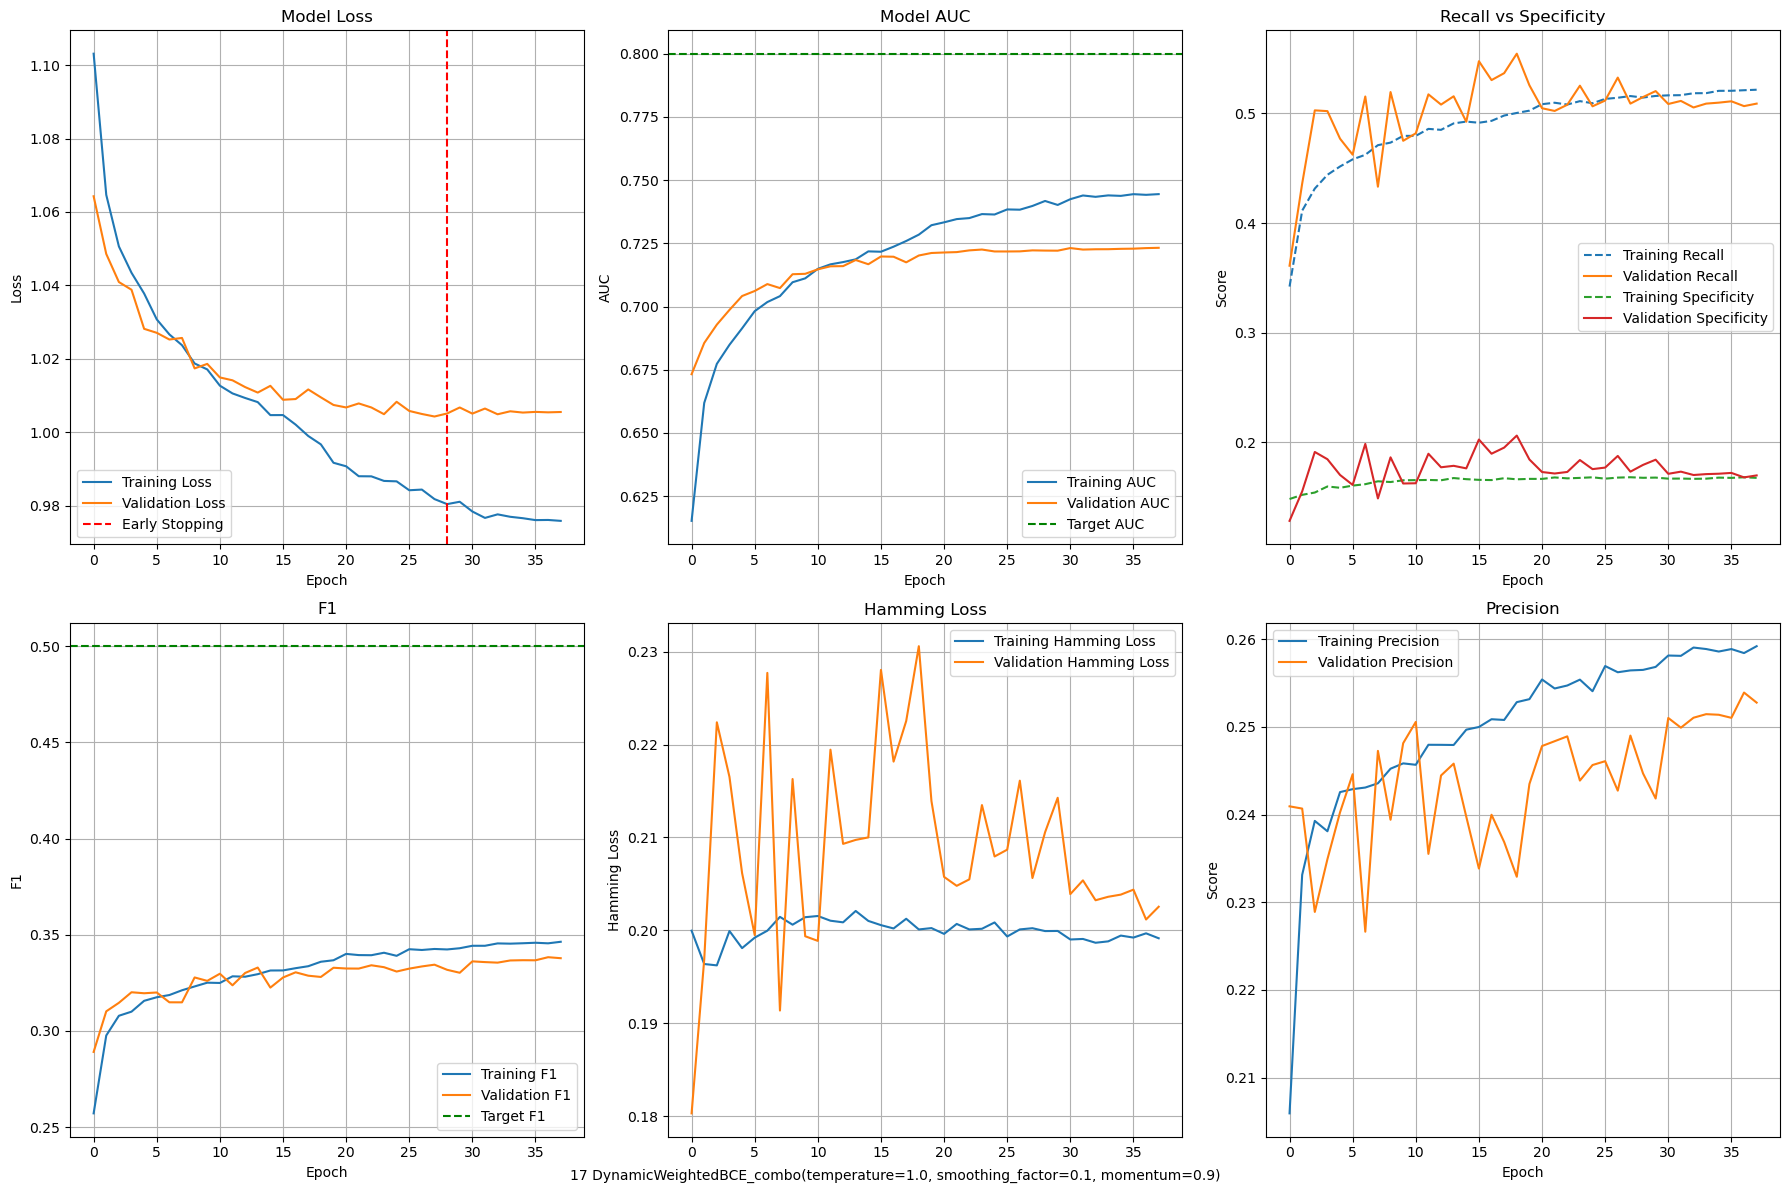

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_history(csv_file='model_statistics/training_history.csv'):
    # Read the CSV file
    history_df = pd.read_csv(csv_file)
    
    # Create figure with subplots in 2 rows
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    
    # First row - original plots
    # Plot loss
    ax1.plot(history_df['loss'], label='Training Loss')
    ax1.plot(history_df['val_loss'], label='Validation Loss')
    if early_stopping.monitor == "val_loss":
        ax1.axvline(x=early_stopping.best_epoch+1, color='r', linestyle='--', label='Early Stopping')
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)
    
    # Plot AUC
    ax2.plot(history_df['auc'], label='Training AUC')
    ax2.plot(history_df['val_auc'], label='Validation AUC')
    ax2.axhline(y=0.80, color='g', linestyle='--', label='Target AUC')
    if early_stopping.monitor == "val_auc":
        ax2.axvline(x=early_stopping.best_epoch+1, color='r', linestyle='--', label='Early Stopping')
    ax2.set_title('Model AUC')
    ax2.set_ylabel('AUC')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    
    # Plot Recall vs Specificity
    ax3.plot(history_df['recall'], '--', label='Training Recall')
    ax3.plot(history_df['val_recall'], label='Validation Recall')
    ax3.plot(history_df['specificity'], '--', label='Training Specificity')
    ax3.plot(history_df['val_specificity'], label='Validation Specificity')
    ax3.set_title('Recall vs Specificity')
    ax3.set_ylabel('Score')
    ax3.set_xlabel('Epoch')
    ax3.legend()
    ax3.grid(True)
    
    # Second row - additional metrics
    # Plot f1
    ax4.plot(history_df['f1'], label='Training F1')
    ax4.plot(history_df['val_f1'], label='Validation F1')
    ax4.axhline(y=0.50, color='g', linestyle='--', label='Target F1')
    ax4.set_title('F1')
    ax4.set_ylabel('F1')
    ax4.set_xlabel('Epoch')
    ax4.legend()
    ax4.grid(True)
    
    # Plot Hamming Loss
    ax5.plot(history_df['hamming_loss'], label='Training Hamming Loss')
    ax5.plot(history_df['val_hamming_loss'], label='Validation Hamming Loss')
    ax5.set_title('Hamming Loss')
    ax5.set_ylabel('Hamming Loss')
    # ax5.set_xlabel('Epoch')
    ax5.legend()
    ax5.grid(True)
    
    # Plot Precision
    ax6.plot(history_df['precision'], label='Training Precision')
    ax6.plot(history_df['val_precision'], label='Validation Precision')
    ax6.set_title('Precision')
    ax6.set_ylabel('Score')
    ax6.set_xlabel('Epoch')
    ax6.legend()
    ax6.grid(True)
    
    plt.tight_layout()
    
    # Add footnote
    plt.figtext(0.5, 0.01, f"{loss_fn_choice} {loss_fn_name}", ha='center', va='bottom')
    
    plt.savefig(f'plot_training_history/plot_training_history_combined_{loss_fn_name}.png', dpi='figure', format='png')
    plt.show()
    plt.close()

plot_training_history()

In [25]:
def evaluate_model_performance(model, test_dataset, df_test, label_text):
    """
    Evaluate model performance with detailed per-class metrics and optimal thresholds
    """
    # Get predictions batch by batch
    all_predictions = []
    all_labels = []
    
    # Iterate through the dataset to get all predictions and labels
    for images, labels in test_dataset:
        pred_batch = model.predict(images, verbose=0)
        all_predictions.append(pred_batch)
        all_labels.append(labels.numpy())
    
    # Concatenate all batches
    y_pred = np.concatenate(all_predictions, axis=0)
    y_true = np.concatenate(all_labels, axis=0)
    
    # Calculate metrics per class
    metrics_per_class = {}
    for i, disease in enumerate(label_text):
        # Find optimal threshold using ROC curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true[:, i], y_pred[:, i])
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        # Create metric instances
        auc_metric = tf.keras.metrics.AUC()
        precision_metric = tf.keras.metrics.Precision()
        recall_metric = tf.keras.metrics.Recall()
        
        # Update and get results using optimal threshold for precision and recall
        auc_metric.update_state(y_true[:, i], y_pred[:, i])
        precision_metric.update_state(y_true[:, i], y_pred[:, i] > optimal_threshold)
        recall_metric.update_state(y_true[:, i], y_pred[:, i] > optimal_threshold)
        
        metrics_per_class[disease] = {
            'auc': auc_metric.result().numpy(),
            'optimal_threshold': optimal_threshold,
            'precision': precision_metric.result().numpy(),
            'recall': recall_metric.result().numpy(),
            'true_positive_rate': np.mean(y_true[:, i]),
            'predicted_positive_rate': np.mean(y_pred[:, i] > optimal_threshold)
        }
    
    # Print results in a readable format
    print("\nPer-class Performance Metrics:")
    print("=" * 50)
    for disease, metrics in metrics_per_class.items():
        print(f"\n{disease}:")
        print(f"  AUC: {metrics['auc']:.3f}")
        print(f"  Optimal threshold: {metrics['optimal_threshold']:.3f}")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall: {metrics['recall']:.3f}")
        print(f"  True positive rate: {metrics['true_positive_rate']:.3f}")
        print(f"  Predicted positive rate: {metrics['predicted_positive_rate']:.3f}")
    
    return metrics_per_class

# After training, evaluate:
metrics_dict = evaluate_model_performance(model, test_dataset, df_test, label_text)

2024-12-28 21:25:39.865715: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Per-class Performance Metrics:

Infiltration:
  AUC: 0.694
  Optimal threshold: 0.426
  Precision: 0.286
  Recall: 0.629
  True positive rate: 0.180
  Predicted positive rate: 0.397

Effusion:
  AUC: 0.811
  Optimal threshold: 0.327
  Precision: 0.242
  Recall: 0.838
  True positive rate: 0.122
  Predicted positive rate: 0.422

Atelectasis:
  AUC: 0.757
  Optimal threshold: 0.413
  Precision: 0.206
  Recall: 0.718
  True positive rate: 0.104
  Predicted positive rate: 0.362

Nodule:
  AUC: 0.647
  Optimal threshold: 0.365
  Precision: 0.092
  Recall: 0.524
  True positive rate: 0.056
  Predicted positive rate: 0.316

Mass:
  AUC: 0.689
  Optimal threshold: 0.318
  Precision: 0.100
  Recall: 0.650
  True positive rate: 0.059
  Predicted positive rate: 0.382


In [26]:
import json
import pandas as pd
import os
import glob
from datetime import datetime
from collections import defaultdict

# Create metrics folder if it doesn't exist
METRICS_DIR = 'metricstracker_files'
os.makedirs(METRICS_DIR, exist_ok=True)

class MetricsTracker:
   def __init__(self):
       self.stats = defaultdict(list)
       
   def add_stats(self, history, loss_fn_name, test_results):
       timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
       
       metrics = {
           'timestamp': timestamp,
           'loss_function': loss_fn_name,
           'val_loss': history.history['val_loss'][-1],
           'best_val_loss': min(history.history['val_loss']),
           'val_f1': history.history['val_f1'][-1],
           'best_val_f1': max(history.history['val_f1']),
           'val_hamming_loss': history.history['val_hamming_loss'][-1],
           'best_val_hamming': min(history.history['val_hamming_loss']),
           'val_auc': history.history['val_auc'][-1],
           'best_val_auc': max(history.history['val_auc']),
           'val_precision': history.history['val_precision'][-1],
           'best_val_precision': max(history.history['val_precision']),
           'val_recall': history.history['val_recall'][-1],
           'best_val_recall': max(history.history['val_recall']),
           'val_specificity': history.history['val_specificity'][-1],
           'best_val_specificity': max(history.history['val_specificity']),
           'epochs_trained': len(history.history['val_loss']),
           'test_metrics': test_results
       }
       
       self.stats[loss_fn_name].append(metrics)
       
       # Save individual run
       json_path = os.path.join(METRICS_DIR, f'training_stats_{timestamp}.json')
       with open(json_path, 'w') as f:
           json.dump(metrics, f, indent=4)
       
       # Append to comparison CSV
       csv_path = os.path.join(METRICS_DIR, 'all_training_stats.csv')
       df = pd.DataFrame([metrics])
       df.to_csv(csv_path, mode='a', header=not os.path.exists(csv_path))

   # Rest of methods remain the same
   def get_stats(self, loss_fn_name=None):
       if loss_fn_name:
           return self.stats[loss_fn_name]
       return dict(self.stats)
       
   def get_summary(self):
       summary = {}
       for loss_fn, runs in self.stats.items():
           if not runs:
               continue
           summary[loss_fn] = {
               'avg_val_f1': sum(run['val_f1'] for run in runs) / len(runs),
               'best_val_f1': max(run['best_val_f1'] for run in runs),
               'avg_val_auc': sum(run['val_auc'] for run in runs) / len(runs),
               'num_runs': len(runs)
           }
           print(f"\nSummary for {loss_fn}:")
           for metric, value in summary[loss_fn].items():
               print(f"{metric}: {value}")
       return summary if summary else {"message": "No training runs recorded yet"}

   def get_best_stats(self):
       best_stats = {}
       for loss_fn, runs in self.stats.items():
           if not runs:
               continue
           best_stats[loss_fn] = {
               'best_val_f1': max(run['best_val_f1'] for run in runs),
               'best_val_auc': max(run['best_val_auc'] for run in runs),
               'best_val_precision': max(run['best_val_precision'] for run in runs),
               'best_val_recall': max(run['best_val_recall'] for run in runs),
               'best_val_specificity': max(run['best_val_specificity'] for run in runs),
               'lowest_val_loss': min(run['best_val_loss'] for run in runs),
               'lowest_hamming_loss': min(run['best_val_hamming'] for run in runs),
               'num_runs': len(runs),
               'timestamps': [run['timestamp'] for run in runs]
           }
           print(f"\nBest metrics for {loss_fn}:")
           for metric, value in best_stats[loss_fn].items():
               if metric != 'timestamps':
                   print(f"{metric}: {value:.4f}")
       return best_stats

def load_previous_stats():
   tracker = MetricsTracker()
   for file in glob.glob(os.path.join(METRICS_DIR, 'training_stats_*.json')):
       with open(file) as f:
           stats = json.load(f)
           tracker.stats[stats['loss_function']].append(stats)
   return tracker

# Create/load tracker
tracker = load_previous_stats()

# Get best stats
best_tracker_stats = tracker.get_best_stats()


Best metrics for WeightedBinaryCrossEntropy_1a(pos_weights_1, neg_weights_1):
best_val_f1: 0.2954
best_val_auc: 0.7246
best_val_precision: 0.1908
best_val_recall: 0.7511
best_val_specificity: 0.4691
lowest_val_loss: 3.0468
lowest_hamming_loss: 0.3169
num_runs: 1.0000

Best metrics for WeightedBinaryCrossEntropy_1a(pos_weights_2, neg_weights_2):
best_val_f1: 0.1967
best_val_auc: 0.7197
best_val_precision: 0.1092
best_val_recall: 0.9998
best_val_specificity: 0.9997
lowest_val_loss: 1.4088
lowest_hamming_loss: 0.8223
num_runs: 1.0000

Best metrics for WeightedBinaryCrossEntropy_1b(pos_weights_1, neg_weights_1):
best_val_f1: 0.2953
best_val_auc: 0.7247
best_val_precision: 0.1917
best_val_recall: 0.7518
best_val_specificity: 0.4523
lowest_val_loss: 0.5347
lowest_hamming_loss: 0.3110
num_runs: 1.0000

Best metrics for WeightedBinaryCrossEntropy_1b(pos_weights_2, neg_weights_2):
best_val_f1: 0.1985
best_val_auc: 0.7178
best_val_precision: 0.1103
best_val_recall: 0.9998
best_val_specificity: 

In [27]:
# After training:
tracker.add_stats(history, loss_fn_name, test_results)
best_tracker_stats = tracker.get_best_stats()


Best metrics for WeightedBinaryCrossEntropy_1a(pos_weights_1, neg_weights_1):
best_val_f1: 0.2954
best_val_auc: 0.7246
best_val_precision: 0.1908
best_val_recall: 0.7511
best_val_specificity: 0.4691
lowest_val_loss: 3.0468
lowest_hamming_loss: 0.3169
num_runs: 1.0000

Best metrics for WeightedBinaryCrossEntropy_1a(pos_weights_2, neg_weights_2):
best_val_f1: 0.1967
best_val_auc: 0.7197
best_val_precision: 0.1092
best_val_recall: 0.9998
best_val_specificity: 0.9997
lowest_val_loss: 1.4088
lowest_hamming_loss: 0.8223
num_runs: 1.0000

Best metrics for WeightedBinaryCrossEntropy_1b(pos_weights_1, neg_weights_1):
best_val_f1: 0.2953
best_val_auc: 0.7247
best_val_precision: 0.1917
best_val_recall: 0.7518
best_val_specificity: 0.4523
lowest_val_loss: 0.5347
lowest_hamming_loss: 0.3110
num_runs: 1.0000

Best metrics for WeightedBinaryCrossEntropy_1b(pos_weights_2, neg_weights_2):
best_val_f1: 0.1985
best_val_auc: 0.7178
best_val_precision: 0.1103
best_val_recall: 0.9998
best_val_specificity: 

In [28]:
import os
import json
import glob
import numpy as np
from datetime import datetime
from collections import defaultdict

METRICS_DIR = 'perclassmetricstracker_files'
os.makedirs(METRICS_DIR, exist_ok=True)

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

class PerClassMetricsTracker:
    def __init__(self):
        self.stats = defaultdict(list)
        
    def add_stats(self, metrics_per_class, loss_fn_name):
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        metrics = {
            'timestamp': timestamp,
            'loss_function': loss_fn_name,
            'per_class_metrics': metrics_per_class
        }
        self.stats[loss_fn_name].append(metrics)
        json_path = os.path.join(METRICS_DIR, f'per_class_metrics_{timestamp}.json')
        with open(json_path, 'w') as f:
            json.dump(metrics, f, cls=NumpyEncoder, indent=4)
            
    def get_best_stats(self):
        best_stats = {}
        for loss_fn, runs in self.stats.items():
            if not runs:
                continue
            per_class_best = {}
            for disease in runs[0]['per_class_metrics'].keys():
                per_class_best[disease] = {
                    'best_auc': max(run['per_class_metrics'][disease]['auc'] for run in runs),
                    'best_precision': max(run['per_class_metrics'][disease]['precision'] for run in runs), 
                    'best_recall': max(run['per_class_metrics'][disease]['recall'] for run in runs),
                    'best_threshold': max(run['per_class_metrics'][disease]['optimal_threshold'] for run in runs)
                }
                print(f"\nBest metrics for {disease} using {loss_fn}:")
                for metric, value in per_class_best[disease].items():
                    print(f"{metric}: {value:.4f}")
            best_stats[loss_fn] = per_class_best
        return best_stats

def load_previous_per_class_stats():
    tracker = PerClassMetricsTracker()
    json_pattern = os.path.join(METRICS_DIR, 'per_class_metrics_*.json')
    for file in glob.glob(json_pattern):
        try:
            with open(file) as f:
                stats = json.load(f)
                tracker.stats[stats['loss_function']].append(stats)
        except json.JSONDecodeError:
            print(f"Skipping corrupted file: {file}")
            # Optional: Remove corrupted file
            # os.remove(file)
    return tracker

per_class_tracker = load_previous_per_class_stats()

In [29]:
# After initialization and loading
best_per_class_stats = per_class_tracker.get_best_stats()

# Then whenever you run a new model:
metrics_dict = evaluate_model_performance(model, test_dataset, df_test, label_text)
per_class_tracker.add_stats(metrics_dict, loss_fn_name)
best_per_class_stats = per_class_tracker.get_best_stats()


Best metrics for Infiltration using WeightedBinaryCrossEntropy_1a(pos_weights_1, neg_weights_1):
best_auc: 0.6919
best_precision: 0.2883
best_recall: 0.6263
best_threshold: 0.4953

Best metrics for Effusion using WeightedBinaryCrossEntropy_1a(pos_weights_1, neg_weights_1):
best_auc: 0.8106
best_precision: 0.2465
best_recall: 0.8336
best_threshold: 0.4715

Best metrics for Atelectasis using WeightedBinaryCrossEntropy_1a(pos_weights_1, neg_weights_1):
best_auc: 0.7572
best_precision: 0.2099
best_recall: 0.7080
best_threshold: 0.5345

Best metrics for Nodule using WeightedBinaryCrossEntropy_1a(pos_weights_1, neg_weights_1):
best_auc: 0.6441
best_precision: 0.0977
best_recall: 0.4661
best_threshold: 0.5573

Best metrics for Mass using WeightedBinaryCrossEntropy_1a(pos_weights_1, neg_weights_1):
best_auc: 0.6894
best_precision: 0.1171
best_recall: 0.5219
best_threshold: 0.5883

Best metrics for Infiltration using WeightedBinaryCrossEntropy_1a(pos_weights_2, neg_weights_2):
best_auc: 0.6939

2024-12-28 21:26:23.982408: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
